In [1]:
# boiler plate
from collections import Counter
import pickle
from importlib import reload
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


import ipdb
import mytf.utils as mu

tf.enable_eager_execution()

print(tf.executing_eagerly())



True


In [2]:
with open('models/2019-05-19T001217-UTC-outdata--SUBSET.pkl', 'rb') as fd:
    minidata = pickle.load(fd)
    

In [3]:
reload(mu)
#Hand-tuned ... 
# Previous weights:
# class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 0.55}

# New weights:
class_weights = {0: 1.0, 1: 1.3, 2: 1.0, 3: 0.9}
training_indices = np.arange(0, minidata['x_train'].shape[0], 1)[:47000]
print('training indices...', training_indices.shape)

dataset_batches = mu.build_dataset_weighty_v3(minidata, training_indices, class_weights,
        batch_size=1000)


training indices... (47000,)
Start build v3: .. doesnt add up to 1.0
num slices 47
size_remainder,  0
Counter({3: 413, 2: 230, 0: 201, 1: 156})
weights_per_class,  tf.Tensor([0.00497512 0.00833333 0.00434783 0.00217918], shape=(4,), dtype=float32)
1005.4999999999907
Counter({3: 428, 0: 213, 2: 198, 1: 161})
weights_per_class,  tf.Tensor([0.00469484 0.00807453 0.00505051 0.0021028 ], shape=(4,), dtype=float32)
1005.49999999999
Counter({3: 410, 0: 217, 2: 215, 1: 158})
weights_per_class,  tf.Tensor([0.00460829 0.00822785 0.00465116 0.00219512], shape=(4,), dtype=float32)
1006.3999999999902
Counter({3: 387, 0: 233, 2: 208, 1: 172})
weights_per_class,  tf.Tensor([0.00429185 0.00755814 0.00480769 0.00232558], shape=(4,), dtype=float32)
1012.8999999999909
Counter({3: 406, 0: 225, 2: 221, 1: 148})
weights_per_class,  tf.Tensor([0.00444444 0.00878378 0.00452489 0.00221675], shape=(4,), dtype=float32)
1003.7999999999904
Counter({3: 395, 0: 230, 2: 192, 1: 183})
weights_per_class,  tf.Tensor([0.

In [5]:
# okay... now try use that ..
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64,   dropout=0.2, recurrent_dropout=0.2,
                batch_input_shape=(None, 256, 1), 
              ),
    # 4 because 'A', 'B', 'C', 'D'.
    tf.keras.layers.Dense(4)
])

%time loss_history = mu.do_train(model, dataset_batches)


Instructions for updating:
Use tf.cast instead.
CPU times: user 6min 9s, sys: 3min 44s, total: 9min 53s
Wall time: 6min 10s


Text(0, 0.5, 'Loss [entropy]')

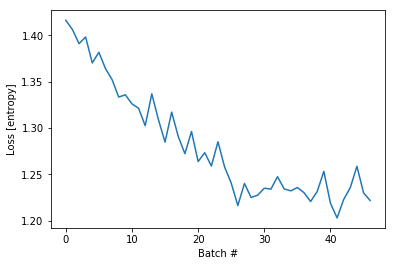

In [6]:
# Loss still pretty small. but Since this is the first time I shuffled, 
# the loss history looks really much more interesting.
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [7]:
print(minidata['x_train'].shape)
train_subset = np.random.choice(np.arange(0, minidata['x_train'].shape[0], 1),
                               10000, replace=False)
print('subset, ', len(train_subset))

# First make sure this random training subset covers all four classes.
print('train subset classes,', Counter(np.argmax(minidata['y_train'][train_subset, :], axis=1)))

%time y_pred_train = model(tf.convert_to_tensor(minidata['x_train'][train_subset], dtype=tf.float32))

# confusion... 
tf.confusion_matrix(
    np.argmax(minidata['y_train'][train_subset, :], axis=1),  # labels

    np.argmax(y_pred_train, axis=1), # predictions
    num_classes=4)



(47689, 256, 1)
subset,  10000
train subset classes, Counter({3: 4208, 2: 2093, 0: 2088, 1: 1611})
CPU times: user 27.3 s, sys: 7.35 s, total: 34.6 s
Wall time: 8.97 s
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor: id=3973761, shape=(4, 4), dtype=int32, numpy=
array([[ 370,    0,    5, 1713],
       [   0,    0,    0, 1611],
       [2091,    0,    0,    2],
       [ 308,    0,   24, 3876]], dtype=int32)>

In [ ]:
# Hmm wow, these weights seem to make a big difference huh.
# So between "2019-07-13-Two" to "2019-07-13-Three" , the only change was to the 
# weights on class=3 , and we went from class=3 being totally ignored , to 
# , class=1 being totally ignored. 